## Siemens: Funtional Data Analysis Pipeline

**Index**

1. Loading the datasets
2. Preprocessing steps
   - 2.1. Data wrangling on time series
   - 2.2. Data wrangling on additional features
   - 2.3. Merging time series datasets to add additional features
       - 2.3.1. Removal of testID only exists in one sensor
3. Window extraction
   - 3.1. Validating if there are partial or full missing values after the extraction
   - 3.2. Validating shape post-window extraction
   - 3.3. Merging scaled data with additional attributes of interest
   - 3.4. Balancing the specific attributes
   - 3.5. Windows visualization (balanced data)
4. FPCA characterization
   - 4.1. Functional PC1 plots (both systems): Characterization of FPC Scores
   - 4.2 Linear Regression for slope
5. Functional Regression
   - 5.1. Regression coefficients
   - 5.2. Coefficients visualization

In [4]:
#!pip install scikit-fda
import os
os.chdir("../../")

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import random
import statsmodels.api as sm
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.projection import FPCA
from skfda.exploratory.visualization import FPCAPlot
from sklearn.preprocessing import OneHotEncoder
import skfda
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import FDataBasis, FourierBasis
from skfda.exploratory.depth import IntegratedDepth, ModifiedBandDepth
from skfda.exploratory.visualization import Boxplot
# Import designed-functions
from window_extraction import calculate_window_values, calculate_window_data, Merge_data, align_to_zero, balance_index
from time_series_visualization import plot_all_time_series, plot_all_time_series_and_mean_fpca, plot_all_time_series_in_group
from functionalPCA import fpca_two_inputs, first_component_extraction, bootstrap, create_pc_scores_plots, visualize_regression
from functional_regression import Function_regression, coefficent_visualization

/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_50574/3302358765.py:9: DeprecationWarning: The module "projection" is deprecated. Please use "dim_reduction"
  from skfda.preprocessing.dim_reduction.projection import FPCA


# 1. Loading the datasets

The path of the files can be change based on where the data is stored.

In [9]:
# Import datasets
sensorA_System1 = pd.read_csv("../../../../RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("../../../../RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("../../../../RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("../../../../RawData/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv("../../../../RawData/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv("../../../../RawData/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv("../../../../RawData/Key by TestID.csv", parse_dates=['DateTime'])

# 2. Preprocesing Steps

## 2.1. Data wrangling on time series

In [10]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [11]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

## 2.2. Data wrangling on additional features

In [12]:
# Relabeling System Values
keyByTestID["System"] = keyByTestID["System"].replace({"System 2A":"System 2","System 2B":"System 2"})

# Create new column to fill fluid temperature NA's
# Note: Fluid temperature: If specified, take as the temperature of the sample fluid. The rest of the system temperature can be taken as ambient temperature.
keyByTestID['Fluid_Temperature_Filled'] = keyByTestID['Fluid Temperature'].combine_first(keyByTestID['AmbientTemperature'])

# Binning 

# Categorize 'FluidType' into Blood and Aqueous
keyByTestID['FluidTypeBin'] = np.where(keyByTestID['FluidType'].str.startswith('Eurotrol'), 'Aqueous', 'Blood')

# Categorize 'AgeOfCardInDaysAtTimeOfTest' into bins
keyByTestID["CardAgeBin"] = pd.cut(keyByTestID["AgeOfCardInDaysAtTimeOfTest"], bins=[0, 9, 28, 56, 84, 112, 140, 168, 196, 224, 252],
                                   labels=['[0-9]', '(9-28]', '(28-56]', '(56-84]', '(84-112]', '(112-140]', '(140-168]', '(168-196]', '(196-224]', '(224-252]'])


# Categorize 'Fluid_Temperature_Filled' into bins
keyByTestID["FluidTempBin"] = pd.cut(keyByTestID["Fluid_Temperature_Filled"], bins=[-1, 20, 25, 100], labels=['Below 20', '20-25', 'Above 25'])

# Filtering successful tests
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

## 2.3. Merging time series datasets to add additional features

In [13]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3382, 3380)
A2:  (7743, 3371)
B1:  (3375, 3380)
B2:  (7745, 3371)


### 2.3.1. Removal of testID only exists in one sensor

In [14]:
# Note: Only run once. If not, restart the kernel and run from the beggining again.
A1_Merged = A1_Merged[A1_Merged["TestID"].isin(B1_Merged["TestID"])]
B1_Merged = B1_Merged[B1_Merged["TestID"].isin(A1_Merged["TestID"])]

A2_Merged = A2_Merged[A2_Merged["TestID"].isin(B2_Merged["TestID"])]
B2_Merged = B2_Merged[B2_Merged["TestID"].isin(A2_Merged["TestID"])]
print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3374, 3380)
A2:  (7743, 3371)
B1:  (3374, 3380)
B2:  (7743, 3371)


# 3. Window extraction

In [15]:
# Match window values of Sensor A for each test

# Sensor A System 1
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

# Sensor A System 2
calDelimit = 9.6
cal_window_size = 8
sampleDelimit = 17.2
sample_window_size = 5

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end


# sensor B

# For sensor B in system 1, blood and aqueous

calDelimit = 20
cal_window_size = 18
sampleDelimit_blood = 24
sampleDelimit_aqueous = 30
sample_window_size = 4

B1_Merged['cal_window_start'], B1_Merged['cal_window_end'], \
B1_Merged['sample_window_start'], B1_Merged['sample_window_end'] = zip(*B1_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit_input=calDelimit,
        cal_window_size_input=cal_window_size,
        sampleDelimit_input=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size_input=sample_window_size
    ),
    axis=1
))

# For sensor B in system 2, blood and aqueous

calDelimit = 18
cal_window_size = 18
sampleDelimit_blood = 30.4
sampleDelimit_aqueous = 32.8
sample_window_size = 4

B2_Merged['cal_window_start'], B2_Merged['cal_window_end'], \
B2_Merged['sample_window_start'], B2_Merged['sample_window_end'] = zip(*B2_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit_input=calDelimit,
        cal_window_size_input=cal_window_size,
        sampleDelimit_input=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size_input=sample_window_size
    ),
    axis=1
))


In [16]:
# Adds TestIDs as index to the values after window extraction 
# System 1 - Sensor A

A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID'].astype(int)
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A

A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID'].astype(int)
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B

B1_cal_window = []
B1_sample_window = []
for i in range(len(B1_Merged)):
    cal_window, sample_window = calculate_window_data(B1_Merged.iloc[i, :])
    B1_cal_window.append(cal_window.values)
    B1_sample_window.append(sample_window.values)
B1_cal_window = pd.DataFrame(B1_cal_window)
B1_sample_window = pd.DataFrame(B1_sample_window)
B1_cal_window['TestID'] = B1_sample_window['TestID'] = B1_Merged['TestID'].astype(int)
B1_sample_window.set_index('TestID',inplace=True)
B1_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor B

B2_cal_window = []
B2_sample_window = []
for i in range(len(B2_Merged)):
    cal_window, sample_window = calculate_window_data(B2_Merged.iloc[i, :])
    B2_cal_window.append(cal_window.values)
    B2_sample_window.append(sample_window.values)
B2_cal_window = pd.DataFrame(B2_cal_window)
B2_sample_window = pd.DataFrame(B2_sample_window)
B2_cal_window['TestID'] = B2_sample_window['TestID'] = B2_Merged['TestID'].astype(int)
B2_sample_window.set_index('TestID',inplace=True)
B2_cal_window.set_index('TestID',inplace=True)

## 3.1. Validating if there are partial or full missing values after the extraction

In [17]:
A1_cal_window_drop_index = A1_cal_window.loc[A1_cal_window.isna().sum(axis=1)!=0].index
A2_cal_window_drop_index = A2_cal_window.loc[A2_cal_window.isna().sum(axis=1)!=0].index

A1_sample_window_drop_index = A1_sample_window.loc[A1_sample_window.isna().sum(axis=1)!=0].index
A2_sample_window_drop_index = A2_sample_window.loc[A2_sample_window.isna().sum(axis=1)!=0].index

B1_cal_window_drop_index = B1_cal_window.loc[B1_cal_window.isna().sum(axis=1)!=0].index
B2_cal_window_drop_index = B2_cal_window.loc[B2_cal_window.isna().sum(axis=1)!=0].index

B1_sample_window_drop_index = B1_sample_window.loc[B1_sample_window.isna().sum(axis=1)!=0].index
B2_sample_window_drop_index = B2_sample_window.loc[B2_sample_window.isna().sum(axis=1)!=0].index

# Check if missing values in different windows is different
print("The missing value in calibration window:",A1_cal_window_drop_index)
print("The missing value in sample window:",A1_sample_window_drop_index)
print("The missing value in calibration window:",A2_cal_window_drop_index)
print("The missing value in sample window:",A2_sample_window_drop_index)

print("The missing value in calibration window:",B1_cal_window_drop_index)
print("The missing value in sample window:",B1_sample_window_drop_index)
print("The missing value in calibration window:",B2_cal_window_drop_index)
print("The missing value in sample window:",B2_sample_window_drop_index)

The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([3561566, 3561567, 3565465, 3565466], dtype='int64', name='TestID')
The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')
The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')


## 3.2. Validating data shape after window extraction

In [18]:
# Set index for Merge datasets
A1_Merged.set_index("TestID", inplace=True)
A2_Merged.set_index("TestID", inplace=True)
B1_Merged.set_index("TestID", inplace=True)
B2_Merged.set_index("TestID", inplace=True)

# Find missing value
print("The problem indexes after extract the window are:",A1_Merged.index.difference(A1_cal_window.index))
print("The problem indexes after extract the window are:",A1_Merged.index.difference(A1_sample_window.index))
print("The problem indexes after extract the window are:",A2_Merged.index.difference(A2_cal_window.index))
print("The problem indexes after extract the window are:",A2_Merged.index.difference(A2_sample_window.index))

print("The problem indexes after extract the window are:",B1_Merged.index.difference(B1_cal_window.index))
print("The problem indexes after extract the window are:",B1_Merged.index.difference(B1_sample_window.index))
print("The problem indexes after extract the window are:",B2_Merged.index.difference(B2_cal_window.index))
print("The problem indexes after extract the window are:",B2_Merged.index.difference(B2_sample_window.index))

A1_Merged = A1_Merged.drop(A1_Merged.index.difference(A1_cal_window.index))
A1_Merged = A1_Merged.drop(A1_Merged.index.difference(A1_sample_window.index))
A2_Merged = A2_Merged.drop(A2_Merged.index.difference(A2_cal_window.index))
A2_Merged = A2_Merged.drop(A2_Merged.index.difference(A2_sample_window.index))

B1_Merged = B1_Merged.drop(B1_Merged.index.difference(B1_cal_window.index))
B1_Merged = B1_Merged.drop(B1_Merged.index.difference(B1_sample_window.index))
B2_Merged = B2_Merged.drop(B2_Merged.index.difference(B2_cal_window.index))
B2_Merged = B2_Merged.drop(B2_Merged.index.difference(B2_sample_window.index))

# Clear the Nan in index of sensor A
A1_cal_window = A1_cal_window[~A1_cal_window.index.isna()]
A1_sample_window = A1_sample_window[~A1_sample_window.index.isna()]
A2_cal_window = A2_cal_window[~A2_cal_window.index.isna()]
A2_sample_window = A2_sample_window[~A2_sample_window.index.isna()]

# Clear the Nan in index of sensor B
B1_cal_window = B1_cal_window[~B1_cal_window.index.isna()]
B1_sample_window = B1_sample_window[~B1_sample_window.index.isna()]
B2_cal_window = B2_cal_window[~B2_cal_window.index.isna()]
B2_sample_window = B2_sample_window[~B2_sample_window.index.isna()]


The problem indexes after extract the window are: Int64Index([12470355, 12470361, 12470365, 12537663, 12539049, 12622570], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([12470355, 12470361, 12470365, 12537663, 12539049, 12622570], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([12622570], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([12622570], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([3518677, 3518678], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([3518677, 3518678], dtype='int64', name='TestID')


In [19]:
# Shape of the subsets of time series after the extraction from the windows

# Cal Window
print('Shape of the time series after extraction')
print('A1_cal_window: ', A1_cal_window.shape)
print('A2_cal_window: ', A2_cal_window.shape)
print('B1_cal_window: ', B1_cal_window.shape)
print('B2_cal_window: ', B2_cal_window.shape)

# Sample Window
print('A1_sample_window: ', A1_sample_window.shape)
print('A2_sample_window: ', A2_sample_window.shape)
print('B1_sample_window: ', B1_sample_window.shape)
print('B2_sample_window: ', B2_sample_window.shape)

# We can delete the unmatch index but it is not necessary

Shape of the time series after extraction
A1_cal_window:  (3368, 41)
A2_cal_window:  (7743, 41)
B1_cal_window:  (3373, 91)
B2_cal_window:  (7741, 91)
A1_sample_window:  (3368, 26)
A2_sample_window:  (7743, 26)
B1_sample_window:  (3373, 21)
B2_sample_window:  (7741, 21)


## 3.3. Merging scaled data with additional attributes of interest

In [20]:
# Combine data: Merge the time series with "FluidType", "AgeOfCardInDaysAtTimeOfTest", "Fluid_Temperature_Filled", "FluidTypeBin", "CardAgeBin", "FluidTempBin"
A1_cal_window_combine = Merge_data(A1_cal_window,A1_Merged)
A2_cal_window_combine = Merge_data(A2_cal_window,A2_Merged)

B1_cal_window_combine = Merge_data(B1_cal_window,B1_Merged)
B2_cal_window_combine = Merge_data(B2_cal_window,B2_Merged)

## Sample window
A1_sample_window_combine = Merge_data(A1_sample_window,A1_Merged)
A2_sample_window_combine = Merge_data(A2_sample_window,A2_Merged)

B1_sample_window_combine = Merge_data(B1_sample_window,B1_Merged)
B2_sample_window_combine = Merge_data(B2_sample_window,B2_Merged)

## 3.4. Balancing the specific attributes

In [21]:
System1_Index, System2_Index =  balance_index(A1_cal_window_combine,A2_cal_window_combine,"CardAgeBin")

System1 Sensor A & B distribution:
 [0-9]        142
(9-28]       142
(28-56]      142
(56-84]      142
(84-112]     142
(112-140]    142
(140-168]    142
(168-196]    142
(196-224]    142
(224-252]    142
Name: CardAgeBin, dtype: int64

 System2 Sensor A & B distribution:
 [0-9]        142
(9-28]       142
(28-56]      142
(56-84]      142
(84-112]     142
(112-140]    142
(140-168]    142
(168-196]    142
(196-224]    142
(224-252]    142
Name: CardAgeBin, dtype: int64


In [22]:
# Balanced data
A1_cal_window_combine_balanced = A1_cal_window_combine.loc[System1_Index]
A1_sample_window_combine_balanced = A1_sample_window_combine.loc[System1_Index]
A2_cal_window_combine_balanced = A2_cal_window_combine.loc[System2_Index]
A2_sample_window_combine_balanced = A2_sample_window_combine.loc[System2_Index]

B1_cal_window_combine_balanced = B1_cal_window_combine.loc[System1_Index]
B1_sample_window_combine_balanced = B1_sample_window_combine.loc[System1_Index]
B2_cal_window_combine_balanced = B2_cal_window_combine.loc[System2_Index]
B2_sample_window_combine_balanced = B2_sample_window_combine.loc[System2_Index]

## 3.5. Windows visualization

### Fluid Temperature

#### System 1 and System 2: Sensor A - Cal and Sample Windows

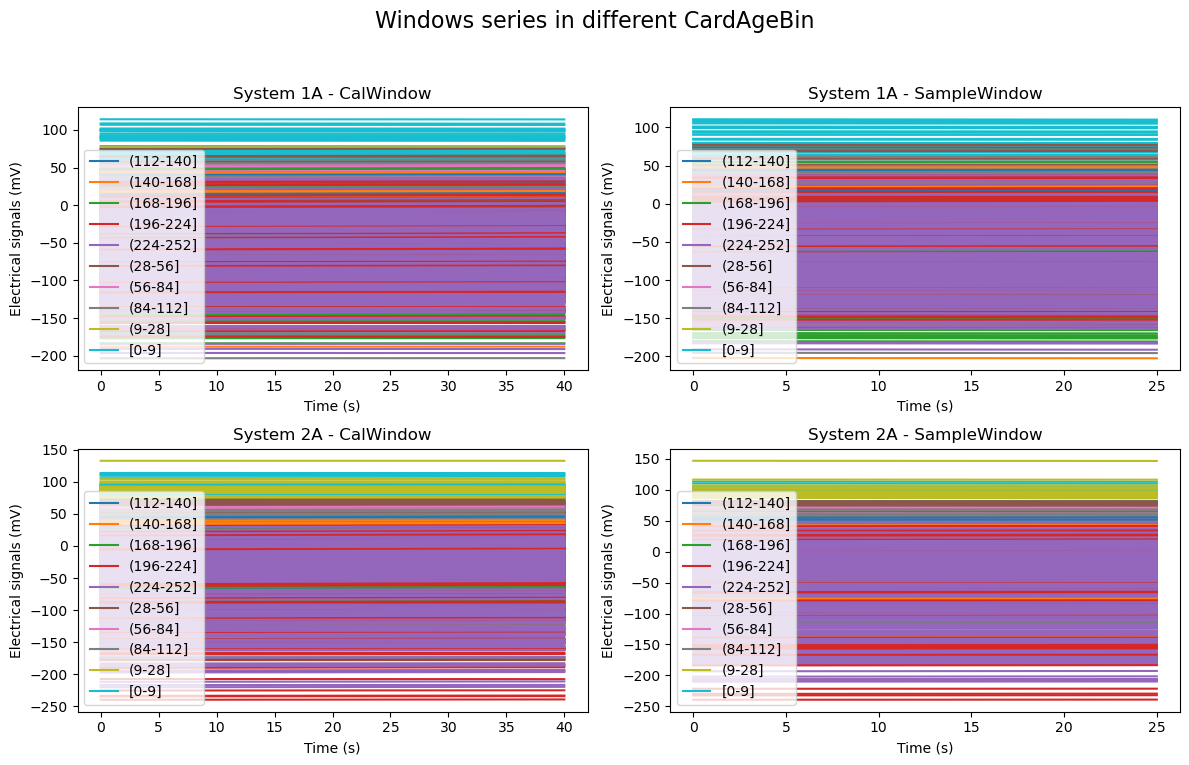

In [23]:
# Plot all the balanced time series from the window extraction
plot_all_time_series_in_group(A1_cal_window_combine_balanced, A1_sample_window_combine_balanced, A2_cal_window_combine_balanced, A2_sample_window_combine_balanced, "CardAgeBin", "System 1A - CalWindow", "System 1A - SampleWindow","System 2A - CalWindow", "System 2A - SampleWindow")

#### System 1 and System 2: Sensor B - Cal and Sample Windows

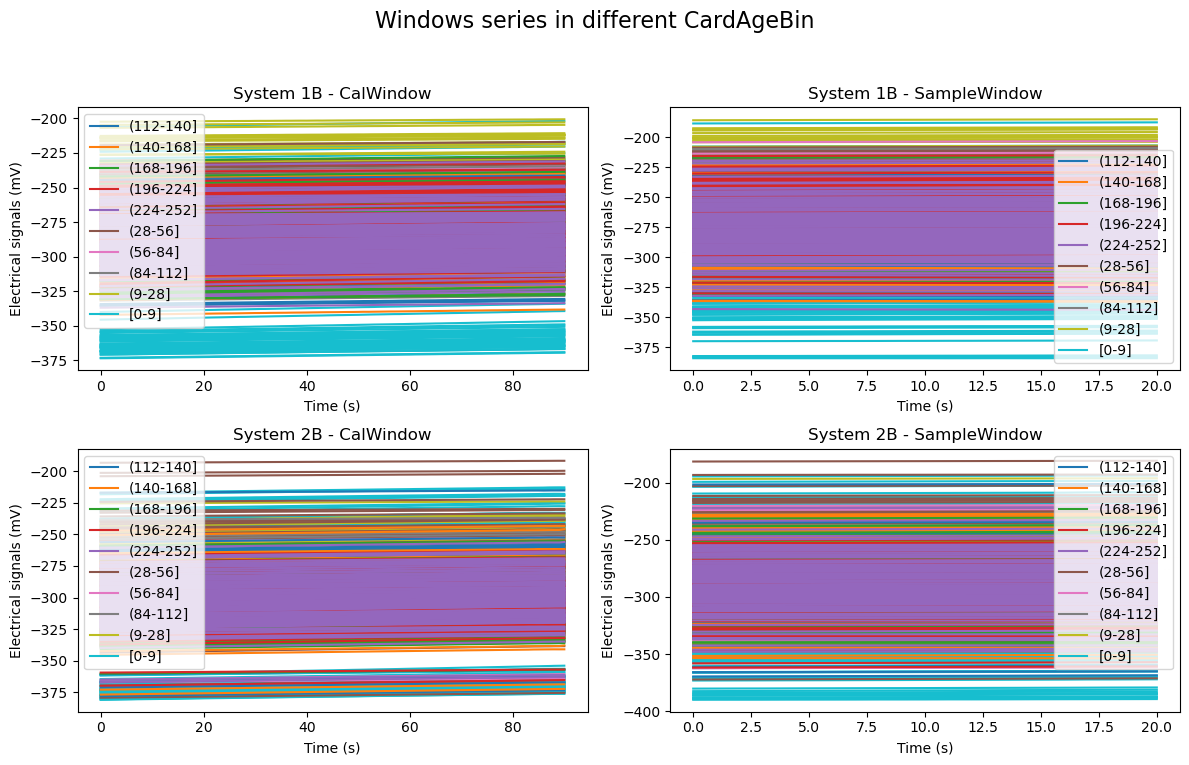

In [24]:
# Plot all the balanced time series from the window extraction
plot_all_time_series_in_group(B1_cal_window_combine_balanced, B1_sample_window_combine_balanced, B2_cal_window_combine_balanced, B2_sample_window_combine_balanced, "CardAgeBin", "System 1B - CalWindow", "System 1B - SampleWindow","System 2B - CalWindow", "System 2B - SampleWindow")


# 4. FPCA characterization

## 4.1. Functional PC1 plots (both systems) and Characterization of FPC Scores

The following seccion will introduce 
1. Percentage of variance explain by the components.
2. Time series with the major contribution on the components.
3. Plot 1-2: All the waveforms and the mean function.
4. Plot 3-4: First two components in different systems.
5. Plot 5: First component (eigenfunction) of the two systems.
6. Plot 6: The confidence interval of the mean first component computed using bootstrap.
7. Plot 7-8: The boxplots of the generated samples of the first component.
   The boxplots show the different percentile about the first component.
    - Red dashed lines indicate detected outliers.
    - Red area shows the box region.
9. Plot 9-12: Eigenvalues (scores) colored-mapping by attributes.

### System 1 versus System 2: Sensor A - Cal Window

S1 Explain variance PC1 (%):  99.9990678032829
S1 Explain variance PC2 (%):  0.0009287030757880157
S2 Explain variance PC1 (%):  99.99922624919061
S2 Explain variance PC2 (%):  0.0007718584885239001
The time series contributing most to PC1 is at index 592 with TestID 12557583.0
The time series contributing most to PC2 is at index 800 with TestID 12529762.0
The time series contributing most to PC1 is at index 1274 with TestID 3572012
The time series contributing most to PC2 is at index 91 with TestID 3568638


/Users/dejaytang/Library/CloudStorage/OneDrive-UBC/2023mds/capstone/Capstone_Siemens/Coding/Nan/FDA_Resampling_new_window/functionalPCA.py:180: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(global_y_FPC1_min, global_y_FPC1_max)


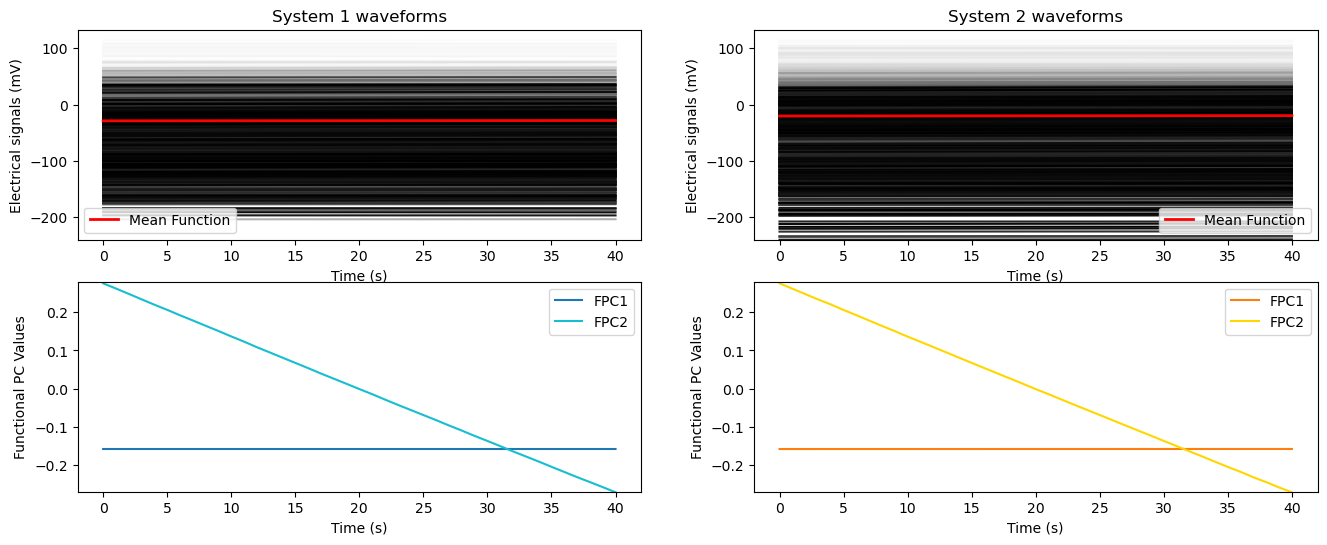

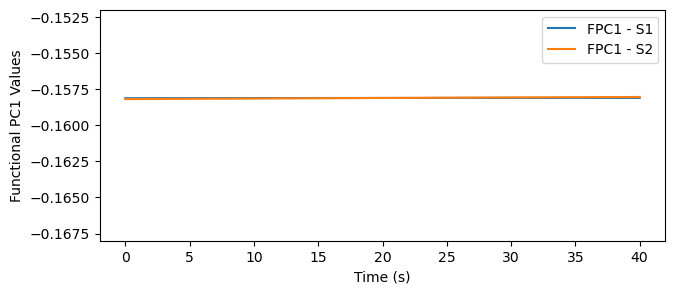

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 142
The boxplot of 1st Component


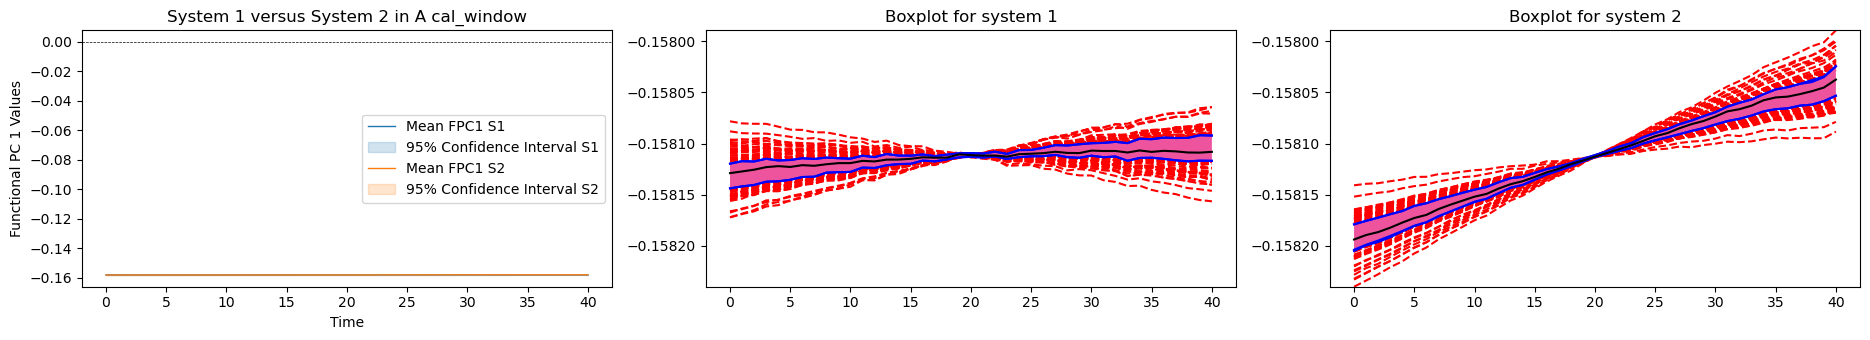

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [25]:
pc_scores_s1_A_cal_window, pc_scores_s2_A_cal_window,fpca_s1_A_cal_window,fpca_s2_A_cal_window = fpca_two_inputs(A1_cal_window_combine_balanced.iloc[:,:-6], A2_cal_window_combine_balanced.iloc[:,:-6], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
ac1, ac2 = bootstrap(A1_cal_window_combine_balanced, A2_cal_window_combine_balanced,"A","cal_window",features="CardAgeBin")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_A_cal_window, pc_scores_s2_A_cal_window, A1_cal_window_combine_balanced, A2_cal_window_combine_balanced,features="CardAgeBin")

### System 1 versus System 2: Sensor A - Sample Window

S1 Explain variance PC1 (%):  99.99971295089487
S1 Explain variance PC2 (%):  0.0002834456263569339
S2 Explain variance PC1 (%):  99.99972553144067
S2 Explain variance PC2 (%):  0.00027336964799600113
The time series contributing most to PC1 is at index 948 with TestID 12573896.0
The time series contributing most to PC2 is at index 800 with TestID 12529762.0
The time series contributing most to PC1 is at index 1152 with TestID 3572286
The time series contributing most to PC2 is at index 140 with TestID 3568703


/Users/dejaytang/Library/CloudStorage/OneDrive-UBC/2023mds/capstone/Capstone_Siemens/Coding/Nan/FDA_Resampling_new_window/functionalPCA.py:180: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(global_y_FPC1_min, global_y_FPC1_max)


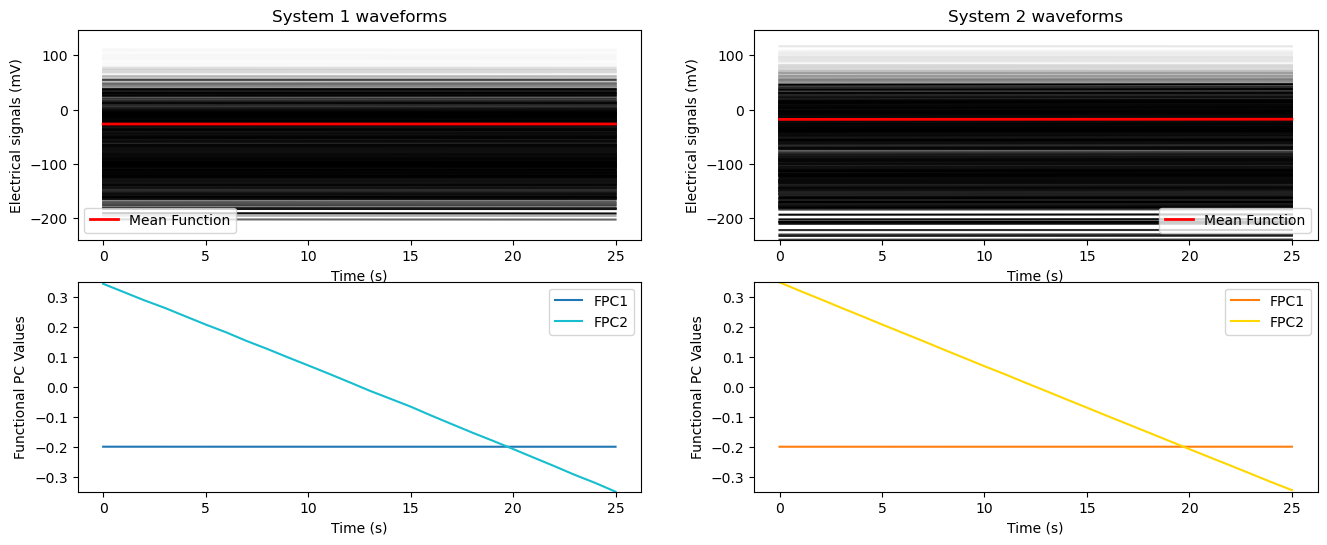

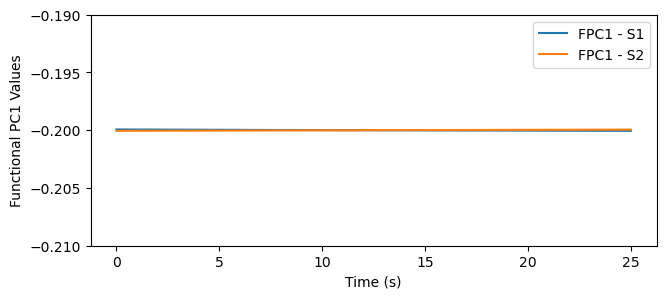

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 142
The boxplot of 1st Component


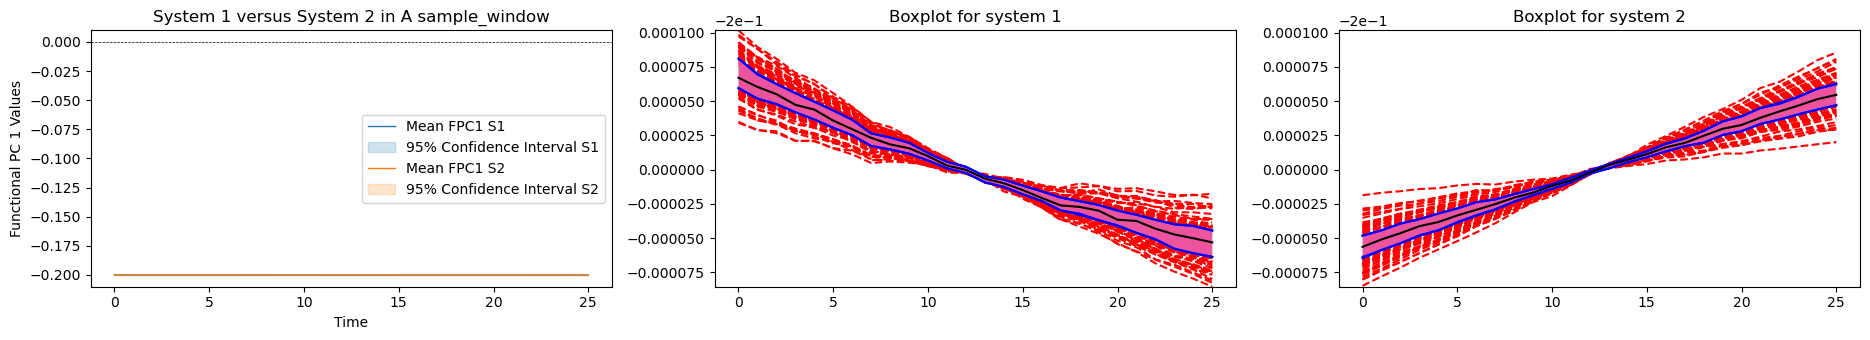

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [26]:
pc_scores_s1_A_sample_window, pc_scores_s2_A_sample_window,fpca_s1_A_sample_window,fpca_s2_A_sample_window = fpca_two_inputs(A1_sample_window_combine_balanced.iloc[:,:-6], A2_sample_window_combine_balanced.iloc[:,:-6], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
as1,as2 = bootstrap(A1_sample_window_combine_balanced, A2_sample_window_combine_balanced,"A","sample_window",features="CardAgeBin")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_A_sample_window, pc_scores_s2_A_sample_window, A1_sample_window_combine_balanced, A2_sample_window_combine_balanced,features="CardAgeBin")

### System 1 versus System 2: Sensor B - Cal Window

S1 Explain variance PC1 (%):  99.99240506760219
S1 Explain variance PC2 (%):  0.007565315856311003
S2 Explain variance PC1 (%):  99.9902292943407
S2 Explain variance PC2 (%):  0.009711969841695535
The time series contributing most to PC1 is at index 133 with TestID 12544066.0
The time series contributing most to PC2 is at index 82 with TestID 12615989.0
The time series contributing most to PC1 is at index 425 with TestID 3556323.0
The time series contributing most to PC2 is at index 53 with TestID 3565690.0


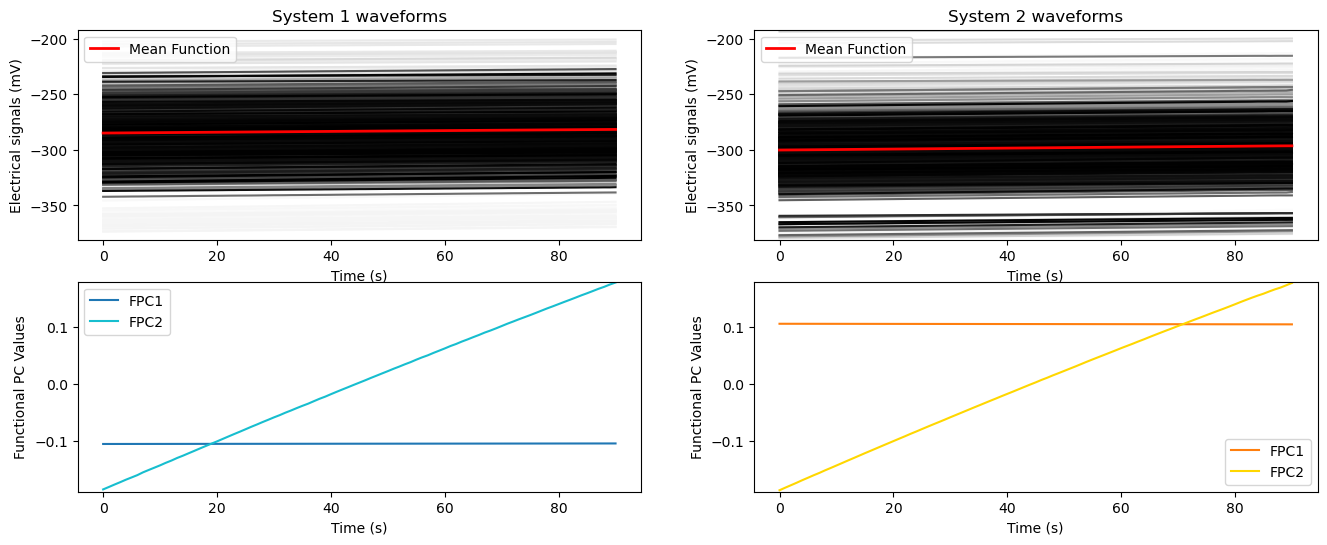

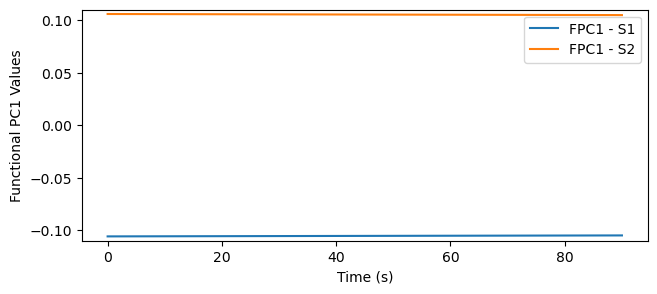

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 142
The boxplot of 1st Component


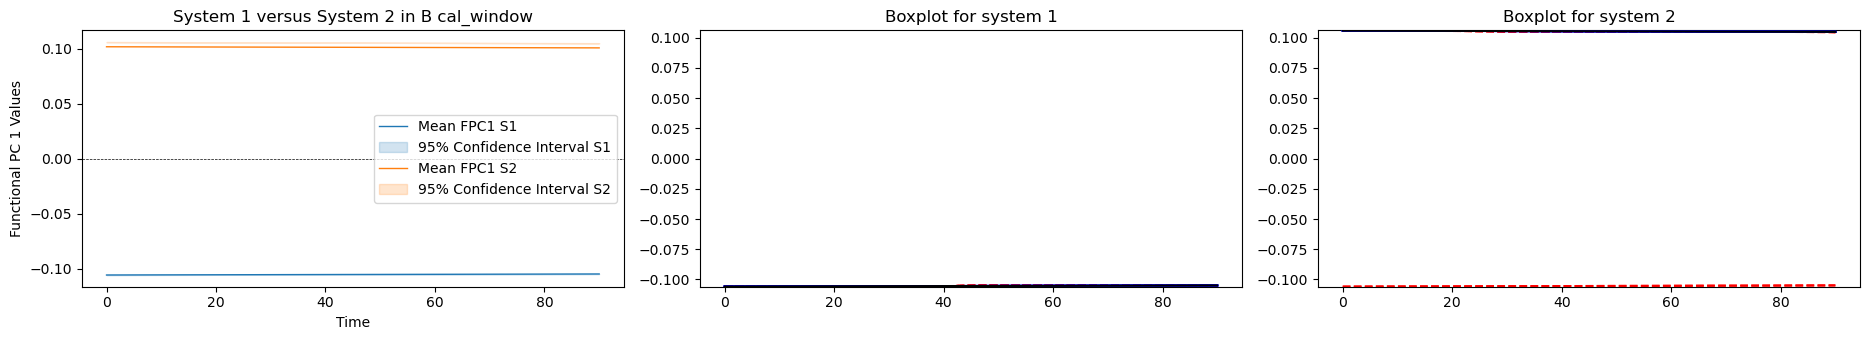

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [27]:
pc_scores_s1_B_cal_window, pc_scores_s2_B_cal_window,fpca_s1_B_cal_window,fpca_s2_B_cal_window = fpca_two_inputs(B1_cal_window_combine_balanced.iloc[:,:-6], B2_cal_window_combine_balanced.iloc[:,:-6], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
bc1,bc2 = bootstrap(B1_cal_window_combine_balanced, B2_cal_window_combine_balanced,"B","cal_window",features="CardAgeBin")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_B_cal_window, pc_scores_s2_B_cal_window, B1_cal_window_combine_balanced, B2_cal_window_combine_balanced,features="CardAgeBin")

### System 1 versus System 2: Sensor B - Sample Window

S1 Explain variance PC1 (%):  99.9983476221513
S1 Explain variance PC2 (%):  0.00164163337985154
S2 Explain variance PC1 (%):  99.9989958556861
S2 Explain variance PC2 (%):  0.0009992914104035627
The time series contributing most to PC1 is at index 78 with TestID 12546583.0
The time series contributing most to PC2 is at index 684 with TestID 12191141.0
The time series contributing most to PC1 is at index 105 with TestID 3560142.0
The time series contributing most to PC2 is at index 666 with TestID 3518710.0


/Users/dejaytang/Library/CloudStorage/OneDrive-UBC/2023mds/capstone/Capstone_Siemens/Coding/Nan/FDA_Resampling_new_window/functionalPCA.py:180: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(global_y_FPC1_min, global_y_FPC1_max)


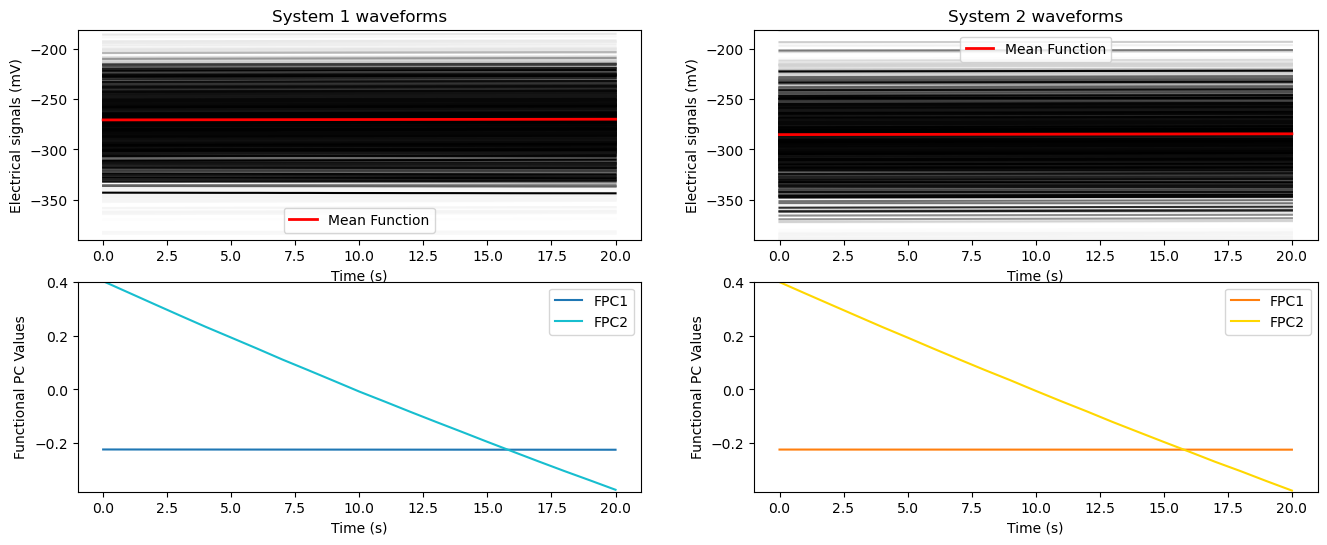

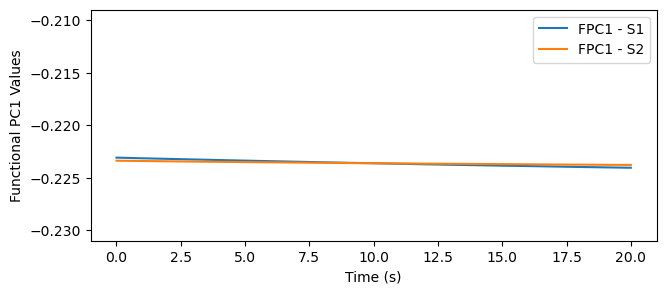

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 142
The boxplot of 1st Component


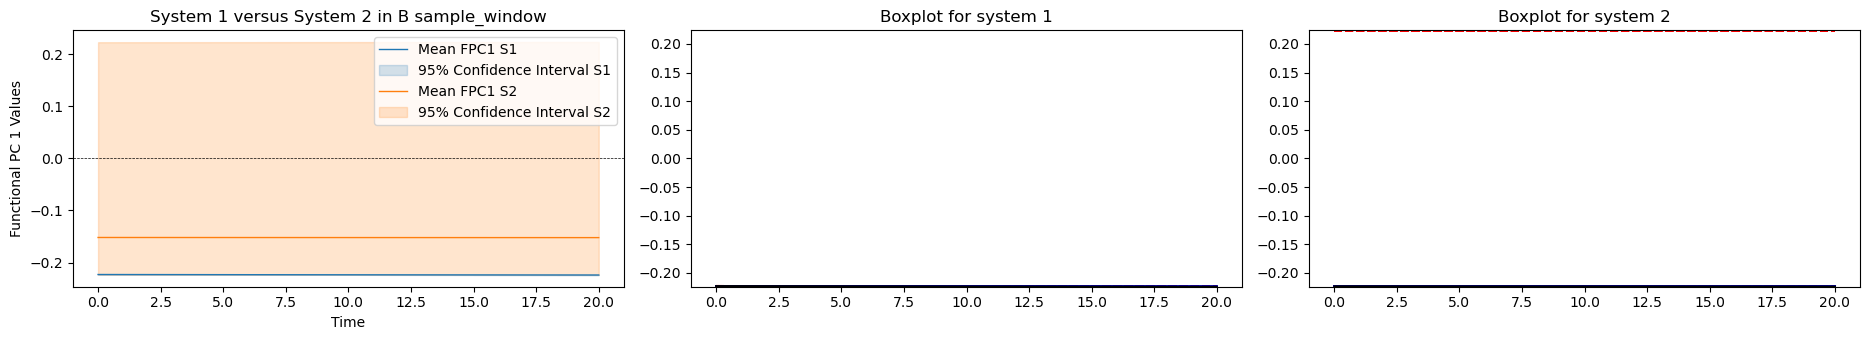

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [28]:
pc_scores_s1_B_sample_window, pc_scores_s2_B_sample_window,fpca_s1_B_sample_window,fpca_s2_B_sample_window = fpca_two_inputs(B1_sample_window_combine_balanced.iloc[:,:-6], B2_sample_window_combine_balanced.iloc[:,:-6], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
bs1,bs2 = bootstrap(B1_sample_window_combine_balanced, B2_sample_window_combine_balanced, "B","sample_window",features="CardAgeBin")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_B_sample_window, pc_scores_s2_B_sample_window, B1_sample_window_combine_balanced, B2_sample_window_combine_balanced,features="CardAgeBin")

## 4.2 Linear Regression for slope

### R-square and visualization

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     499.0
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           7.84e-24
Time:                        18:39:51   Log-Likelihood:                 480.75
No. Observations:                  41   AIC:                            -957.5
Df Residuals:                      39   BIC:                            -954.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1581   6.15e-07  -2.57e+05      0.0

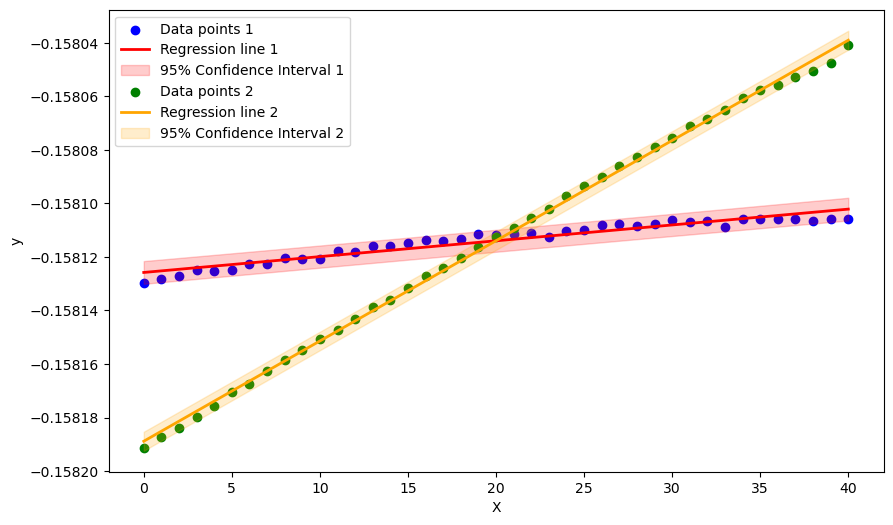

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2328.
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           2.07e-25
Time:                        18:39:51   Log-Likelihood:                 288.65
No. Observations:                  26   AIC:                            -573.3
Df Residuals:                      24   BIC:                            -570.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1999   1.45e-06  -1.38e+05      0.0

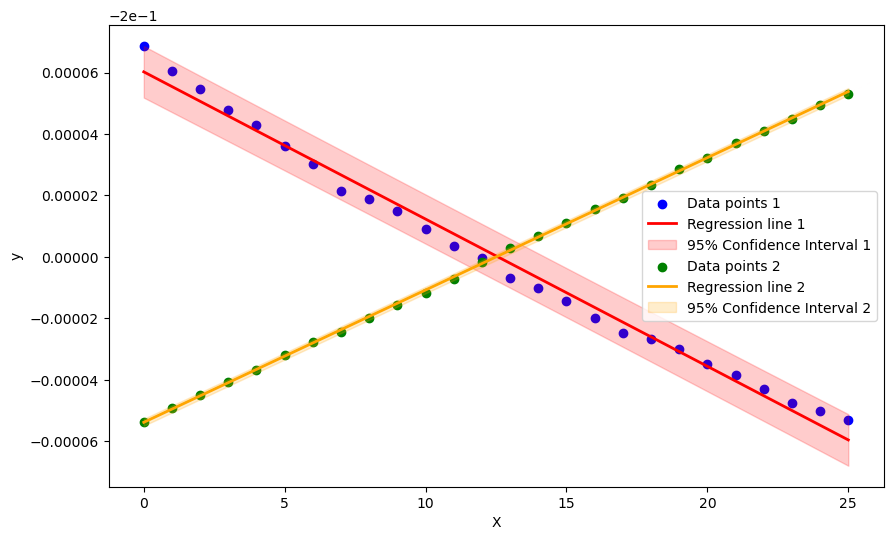

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.382e+05
Date:                Sat, 15 Jun 2024   Prob (F-statistic):          3.45e-176
Time:                        18:39:51   Log-Likelihood:                 1028.7
No. Observations:                  91   AIC:                            -2053.
Df Residuals:                      89   BIC:                            -2048.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1059   6.27e-07  -1.69e+05      0.0

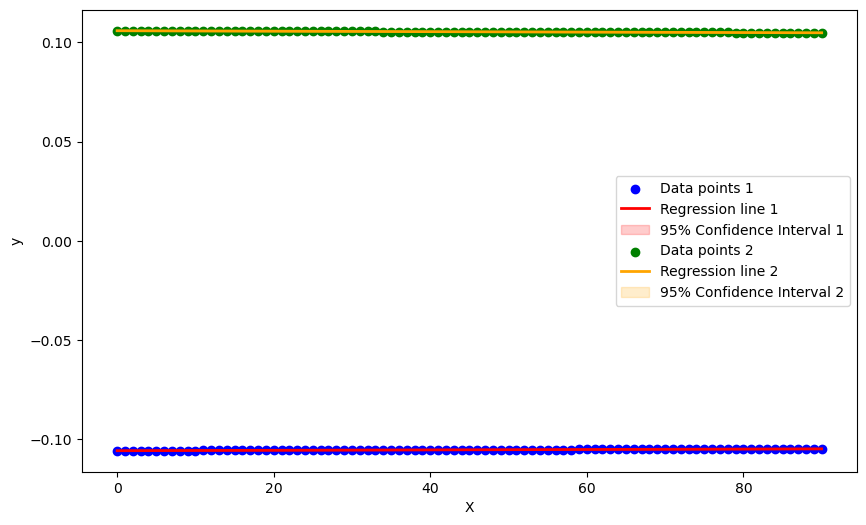

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     4620.
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           3.76e-24
Time:                        18:39:51   Log-Likelihood:                 198.85
No. Observations:                  21   AIC:                            -393.7
Df Residuals:                      19   BIC:                            -391.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2231   8.28e-06   -2.7e+04      0.0

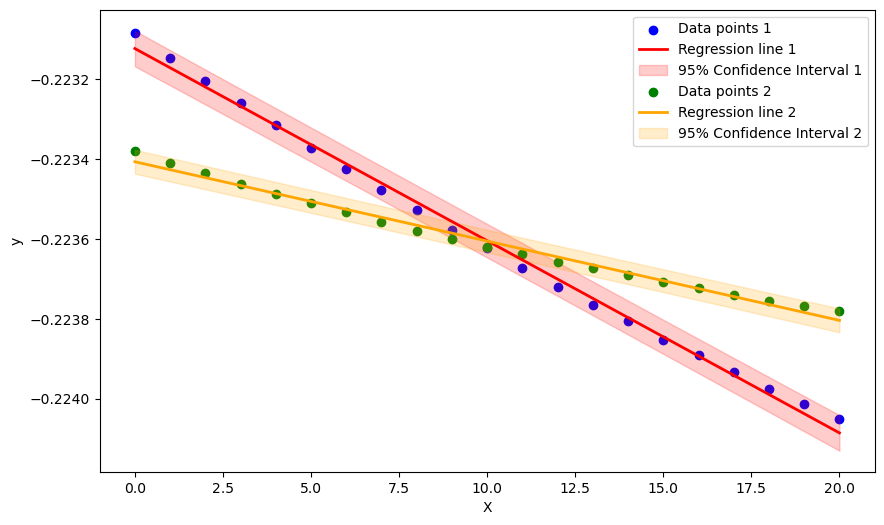

In [29]:
df_list = []

def append_to_dataframe(window_name, slope1, slope2):
    global df_list
    df_list.append({'Window': window_name, 'Slope 1': slope1, 'Slope 2': slope2})
append_to_dataframe('A_cal_window', *visualize_regression(fpca_s1_A_cal_window, fpca_s2_A_cal_window))
append_to_dataframe('A_sample_window', *visualize_regression(fpca_s1_A_sample_window, fpca_s2_A_sample_window))
append_to_dataframe('B_cal_window', *visualize_regression(fpca_s1_B_cal_window, fpca_s2_B_cal_window))
append_to_dataframe('B_sample_window', *visualize_regression(fpca_s1_B_sample_window, fpca_s2_B_sample_window))

### Slopes Results Comparison for one sample

In [30]:
slopes_df = pd.DataFrame(df_list)
slopes_df

Window       Slope 1   Slope 2
0     A_cal_window  5.913307e-07  0.000004
1  A_sample_window -4.792280e-06  0.000004
2     B_cal_window  1.033637e-05 -0.000011
3  B_sample_window -4.811958e-05 -0.000020

# 5. Functional Regression

This is another functional Data Analysis method. Unlike FPCA, the following analysis utilizes **the entire time series** in a balanced and centered dataset as response variables for regression with **the features grouped by bins**. This is done to distinguish between two systems under the influence of features.

## 5.1. Regression coefficients

These are the coefficients from the output of the model.
- Note: In the visualizations, due to the different magnitude, we need to choose the time stamps before we visualize.

### Sensor A

#### Cal window

In [31]:
print("System 1:")
A1_cal_window_funct_reg = Function_regression(A1_cal_window_combine_balanced,40,['AgeOfCardInDaysAtTimeOfTest'])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_cal_window_funct_reg = Function_regression(A2_cal_window_combine_balanced,40,['AgeOfCardInDaysAtTimeOfTest'])

System 1:
Model Summary: 

Intercept: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 40.0),), n_basis=41, period=40.0),
    coefficients=[[ 1.12969934e+02 -2.54087869e-01 -6.16478393e-02  4.26477462e-02
      -1.55955210e-01 -2.04932193e-01  6.98070470e-02 -1.07249592e-02
      -1.97358451e-01  2.62929686e-01  6.94883436e-02 -2.02584680e-01
       1.98420073e-01 -7.16210555e-02  1.68070284e-01 -4.90006365e-02
       2.98174620e-01 -9.36189532e-03  2.26980579e-01 -4.54559332e-01
       9.45223291e-02  1.08290355e-01  8.54976365e-02 -1.09581495e-01
       1.06591476e-02 -9.73530024e-03  2.03426158e-03 -1.90255820e-01
       3.99508688e-02 -4.78771163e-01  1.73005869e-01  4.45503135e-03
      -3.30847265e-01  1.85403260e-01  3.05801586e-02 -2.28451401e-01
       5.71844662e-02 -2.75866281e-01  7.50141766e-02 -1.85441728e+14
      -4.65345409e-01]]) 

Coefficient of AgeOfCardInDaysAtTimeOfTest: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 40.0),), n_basis=41, period=40.

#### Sample window

In [32]:
print("System 1:")
A1_sample_window_funct_reg = Function_regression(A1_sample_window_combine_balanced,25,["AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_sample_window_funct_reg = Function_regression(A2_sample_window_combine_balanced,25,["AgeOfCardInDaysAtTimeOfTest"])


System 1:
Model Summary: 

Intercept: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 25.0),), n_basis=25, period=25.0),
    coefficients=[[8.61205375e+01 1.27088143e-01 1.91328493e-02 6.35335880e-02
      5.06505700e-03 4.12161405e-02 2.54016366e-03 3.00481128e-02
      1.01510836e-03 2.29581338e-02 9.43264471e-04 1.70733857e-02
      7.30546035e-04 1.30920595e-02 4.25301550e-04 1.06563585e-02
      4.68470296e-04 7.46018237e-03 5.95669041e-04 5.43748127e-03
      8.96060131e-05 3.22866589e-03 4.07170310e-04 1.44224073e-03
      2.19040425e-04]]) 

Coefficient of AgeOfCardInDaysAtTimeOfTest: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 25.0),), n_basis=25, period=25.0),
    coefficients=[[-1.96813078e+00 -1.81712557e-03  6.61561593e-05 -8.89158533e-04
       1.63223556e-05 -5.72415295e-04  7.71483667e-06 -4.17648193e-04
       6.88451146e-06 -3.16525794e-04  7.13968548e-08 -2.38887920e-04
       3.88757879e-06 -1.83242005e-04 -3.46688201e-07 -1.51261251e-04
       4

### Sensor B

#### Cal window

In [33]:
print("System 1:")
B1_cal_window_funct_reg = Function_regression(B1_cal_window_combine_balanced,90,["AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
B2_cal_window_funct_reg = Function_regression(B2_cal_window_combine_balanced,90,["AgeOfCardInDaysAtTimeOfTest"])

System 1:
Model Summary: 

Intercept: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 90.0),), n_basis=91, period=90.0),
    coefficients=[[-2.65583522e+03 -3.30129041e+00 -9.30975751e+00  2.83933817e+00
      -6.07673825e+00  7.82963792e+00 -2.86916728e+00  3.53985118e+00
       1.18964728e+00 -3.38110939e+00  4.12124493e+00 -3.35693442e+00
      -8.26391414e+00  1.22183372e+00  3.99370546e+00 -3.64919518e+00
      -4.80260271e+00 -1.15372824e+00 -2.30116974e+00  3.22014780e+00
      -1.46994983e+01  1.66019841e+01  1.65207352e+01 -1.31892215e+01
      -1.10048244e+01  2.64561780e+00 -8.18122621e+00  9.62968584e+00
      -4.40665826e+00  9.68428087e+00 -4.35548230e+00  1.46960509e+01
       5.99791635e+00 -2.60883738e+00  8.27400875e+00  3.38760283e+00
       1.77457892e+00  4.08949657e+00  4.78311751e+00  2.02944618e+00
       4.07984148e+00  4.31230003e+00  2.59722228e-01 -7.90494435e+00
       2.91802719e+00 -7.01100420e+00 -2.78555547e+00  1.10457704e+01
       7.16237017e

#### Sample window

In [34]:
print("System 1:")
B1_sample_window_funct_reg = Function_regression(B1_sample_window_combine_balanced,20,["AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
B2_sample_window_funct_reg = Function_regression(B2_sample_window_combine_balanced,20,["AgeOfCardInDaysAtTimeOfTest"])

System 1:
Model Summary: 

Intercept: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 20.0),), n_basis=21, period=20.0),
    coefficients=[[-1.19992659e+03 -6.14445230e-01  1.77863892e-02 -3.36699448e-01
       6.05370916e-01 -3.90224307e-01  2.16845388e-01 -5.04402509e-01
       1.42760995e+00 -2.19838625e+00  1.81664241e-01 -9.34748467e-02
      -1.16362905e+00 -3.41843459e-01  2.06659549e-01 -3.10065648e-01
       1.12370925e-01 -7.56605926e-01  1.28720853e-01 -1.01349493e+15
      -1.40219641e+00]]) 

Coefficient of AgeOfCardInDaysAtTimeOfTest: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 20.0),), n_basis=21, period=20.0),
    coefficients=[[-7.79503415e-02 -5.89679082e-04 -2.66420720e-04 -3.61952375e-04
      -1.58443378e-03  7.61804146e-04 -1.53152449e-03  1.09224567e-03
      -2.97066289e-03  1.48850257e-03 -9.42854582e-05 -1.30842863e-03
       6.10766774e-04  2.70876113e-04 -1.68424390e-03 -1.31747076e-03
      -2.85573605e-03 -1.49575364e-03 -2.90301361e-04

## 5.2. Coefficients visualization

### Sensor A

#### Cal window

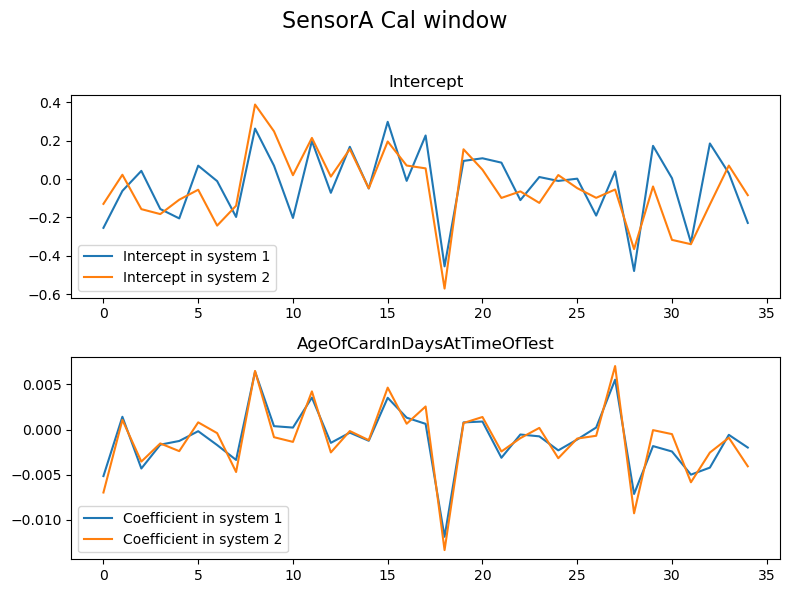

In [35]:
coefficent_visualization(A1_cal_window_funct_reg,A2_cal_window_funct_reg,["AgeOfCardInDaysAtTimeOfTest"],range(1,36),"SensorA Cal window")

#### Sample window

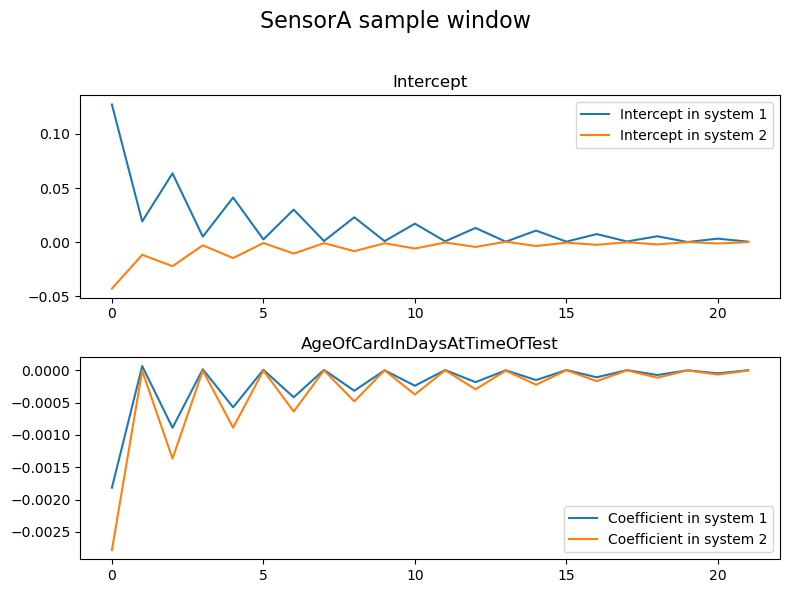

In [36]:
coefficent_visualization(A1_sample_window_funct_reg,A2_sample_window_funct_reg,["AgeOfCardInDaysAtTimeOfTest"],range(1,23),"SensorA sample window")

### Sensor B

#### Cal window

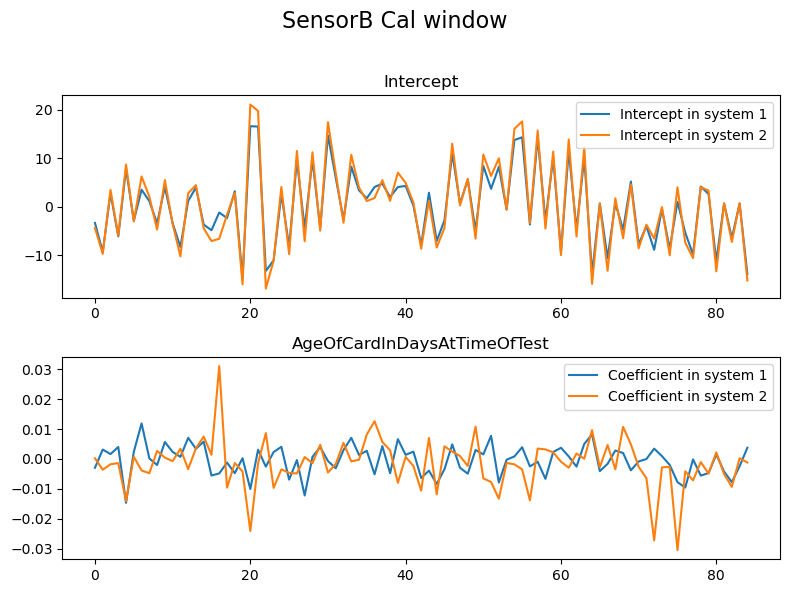

In [37]:
coefficent_visualization(B1_cal_window_funct_reg,B2_cal_window_funct_reg,["AgeOfCardInDaysAtTimeOfTest"],range(1,86),"SensorB Cal window")

#### Sample window

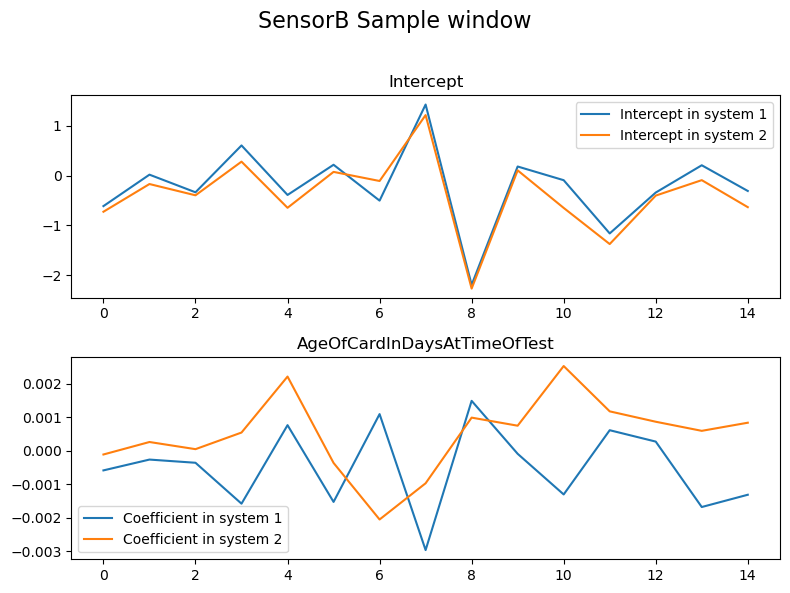

In [38]:
coefficent_visualization(B1_sample_window_funct_reg, B2_sample_window_funct_reg, ["AgeOfCardInDaysAtTimeOfTest"], range(1, 16), "SensorB Sample window")